# [Simple MNIST NN from scratch (numpy, no TF/Keras)](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras)

오직 넘파이를 가지고 신경망의 기본 수학을 이해할 수 있는 코드가 있어 같이 보려고 합니다.   

작성자의 영상 설명도 있는 코드입니다.   
 더욱 자세히 알고싶다면 유튜브를 보며 따라가도 좋을 것 같습니다.  https://youtu.be/w8yWXqWQYmU



# 라이브러리 불러오기

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 데이터 확인

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Kaggle_study/Digit_Recognizer_MNIST/data/train.csv')

In [5]:
data = np.array(data)
data_num = data.shape[0]
print(data.shape)

(42000, 785)


학습 이미지는 총 13766개가 있고 데이터의 첫번째 값은 라벨을 의미하고 나머지 784는 $28*28*1$의 이미지를 의미한다.

In [6]:
np.random.shuffle(data) # 데이터 셔플링

# 학습(train), 검증(validation)데이터 분할
train_val_rate = 0.1

train_data = data[int(data_num*train_val_rate):data_num].T
validation_data = data[0:int(data_num*train_val_rate)].T

print(f"학습 데이터 shape : {train_data.shape}")
print(f"검증 데이터 shape : {validation_data.shape}")

학습 데이터 shape : (785, 37800)
검증 데이터 shape : (785, 4200)


In [7]:
# 위의 데이터를 Transpose 하는 이유
a = [[0,12,5,13,23,251,3,3,2,51], \
     [0,3,215,23,13,31,315,2,3,1], \
     [0,2,2,63,53,31,6,34,23,61], \
     [0,1,2,53,33,51,6,3,1,1]]
# 위 리스트에서 0에 접근 하기 위해서는 다음과 같이 해야한다.
[i[0] for i in a]

[0, 0, 0, 0]

In [8]:
# 그러나 a를 Transpose한다면 다음과 같다.
a = [[0,0,0,0], \
    [12,3,2,1],\
    [5,215,2,2],\
    [13,23,63,53],\
    [23,13,53,33],\
    [251,31,31,51],\
    [3,315,6,6],\
    [3,2,34,3],\
    [2,3,23,1],\
    [51,1,61,1]]
# 다음 처럼 모든 리스트의 첫째 값을 추출할 수 있다.
a[0]

[0, 0, 0, 0]

In [9]:
# 이어서 학습 데이터와 검증데이터를 라벨과 데이터로 나눈다.
train = train_data[1:] / 255.
label = train_data[0]

val = validation_data[1:] / 255.
val_label = validation_data[0]

train_num = train.shape[1]

print(f"학습 데이터 shape : {train.shape}, label : {label.shape}")
print(f"검증 데이터 shape : {val.shape}, label : {val_label.shape}")

학습 데이터 shape : (784, 37800), label : (37800,)
검증 데이터 shape : (784, 4200), label : (4200,)


## 모델 설계
단순 2계층 Neural Network를 설계할 것 이다.


<img src="https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/0ad35506-95d5-4fb1-a262-b902b2d1354d" width="500" height="300">

In [10]:
# 가중치 초기 설정
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

## forward propagation
$$Z^{[1]} = W^{[1]}X+b^{[1]}$$
$$A^{[1]} = \text{Relu}(Z^{[1]})$$
$$Z^{[2]} = W^{[2]}A^{[1]}+b^{[2]}$$
$$A^{[2]} = \text{softmax}(Z^{[2]})$$


In [11]:
def ReLU(Z):
  return np.maximum(Z, 0)

def softmax(Z):
  A = np.exp(Z) / sum(np.exp(Z))
  return A

def forward_prop(W1, b1, W2, b2, X):
  Z1 = W1.dot(X) + b1
  A1 = ReLU(Z1)
  Z2 = W2.dot(A1) + b2
  A2 = softmax(Z2)
  return Z1, A1, Z2, A2

## backward propagation
$$dZ^{[2]}=A^{[2]}-Y$$
$$dW^{[2]}=\frac{1}{m}dZ^{[2]}A^{[1]T}$$
$$dB^{[2]}=\frac{1}{m}\sum dZ^{[2]}$$
$$dZ^{[1]}=W^{[2]T}dZ^{[2]} * \text{Relu}_{grad}(Z^{[1]})$$
$$dW^{[1]}=\frac{1}{m}dZ^{[1]}X^{T}$$
$$dB^{[1]}=\frac{1}{m}\sum dZ^{[1]}$$

where. $m = \text{batch_size}$ 여기서는 전체 데이터

In [12]:
def ReLU_deriv(Z):
  return Z > 0

def one_hot(Y):
  one_hot_Y = np.zeros((Y.size, Y.max() + 1))
  one_hot_Y[np.arange(Y.size), Y] = 1
  one_hot_Y = one_hot_Y.T
  return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
  global train_num
  one_hot_Y = one_hot(Y)
  dZ2 = A2 - one_hot_Y
  dW2 = 1 / train_num * dZ2.dot(A1.T)
  db2 = 1 / train_num * np.sum(dZ2)
  dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
  dW1 = 1 / train_num * dZ1.dot(X.T)
  db1 = 1 / train_num * np.sum(dZ1)
  return dW1, db1, dW2, db2


## 학습

In [13]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
  W1 = W1 - alpha * dW1
  b1 = b1 - alpha * db1
  W2 = W2 - alpha * dW2
  b2 = b2 - alpha * db2
  return W1, b1, W2, b2

def get_predictions(A2):
  return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
  print(predictions, Y)
  return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, learning_rate, iterations):
  W1, b1, W2, b2 = init_params()
  for i in range(iterations):
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    if i % 10 == 0:
      print("Iteration: ", i)
      predictions = get_predictions(A2)
      print(get_accuracy(predictions, Y))
  return W1, b1, W2, b2

In [14]:
W1, b1, W2, b2 = gradient_descent(train, label, 0.10, 500)

Iteration:  0
[9 0 9 ... 8 9 0] [1 0 6 ... 4 1 0]
0.10322751322751322
Iteration:  10
[0 0 9 ... 8 9 0] [1 0 6 ... 4 1 0]
0.14177248677248677
Iteration:  20
[0 0 9 ... 7 1 0] [1 0 6 ... 4 1 0]
0.25817460317460317
Iteration:  30
[0 0 2 ... 7 1 0] [1 0 6 ... 4 1 0]
0.34314814814814815
Iteration:  40
[0 0 2 ... 7 1 0] [1 0 6 ... 4 1 0]
0.40066137566137566
Iteration:  50
[1 0 2 ... 7 1 0] [1 0 6 ... 4 1 0]
0.4581216931216931
Iteration:  60
[1 0 6 ... 7 1 0] [1 0 6 ... 4 1 0]
0.5027248677248677
Iteration:  70
[1 0 6 ... 7 1 0] [1 0 6 ... 4 1 0]
0.5347354497354497
Iteration:  80
[1 0 6 ... 7 1 0] [1 0 6 ... 4 1 0]
0.5599206349206349
Iteration:  90
[1 0 6 ... 7 1 0] [1 0 6 ... 4 1 0]
0.5798941798941799
Iteration:  100
[1 0 6 ... 7 1 0] [1 0 6 ... 4 1 0]
0.5971428571428572
Iteration:  110
[1 0 6 ... 4 1 0] [1 0 6 ... 4 1 0]
0.6122222222222222
Iteration:  120
[1 0 6 ... 4 1 0] [1 0 6 ... 4 1 0]
0.6262962962962964
Iteration:  130
[1 0 6 ... 4 1 0] [1 0 6 ... 4 1 0]
0.6387037037037037
Iteration:  

In [18]:
def make_predictions(X, W1, b1, W2, b2):
  _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
  predictions = get_predictions(A2)
  return predictions

def test_prediction(index, W1, b1, W2, b2):
  current_image = train[:, index, None]
  prediction = make_predictions(train[:, index, None], W1, b1, W2, b2)
  Y = label[index]
  print("Prediction: ", prediction)
  print("Label: ", Y)

  current_image = current_image.reshape((28, 28)) * 255
  plt.gray()
  plt.imshow(current_image, interpolation='nearest')
  plt.show()

Prediction:  [1]
Label:  1


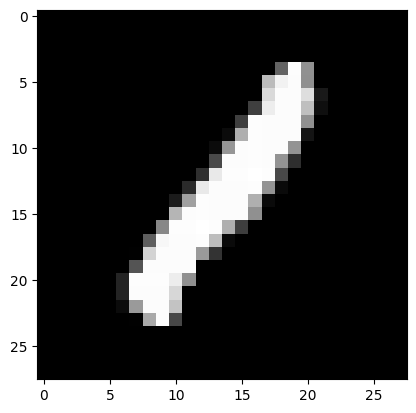

Prediction:  [0]
Label:  0


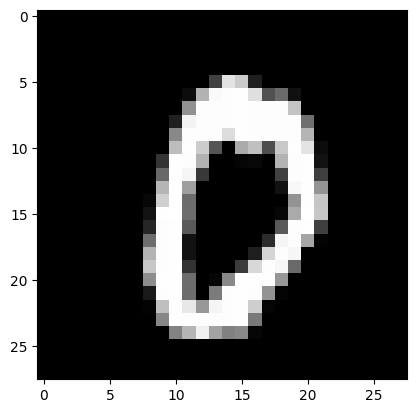

Prediction:  [6]
Label:  6


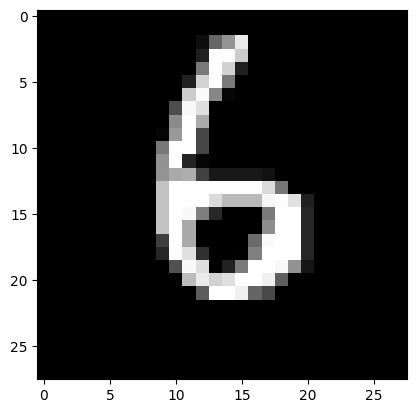

Prediction:  [1]
Label:  1


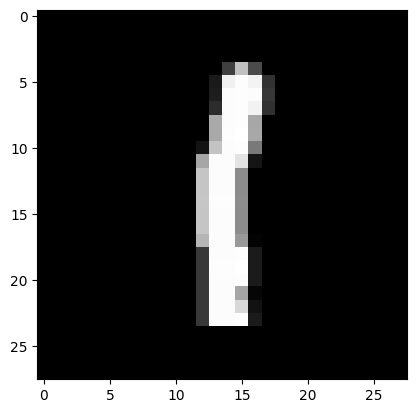

In [19]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [20]:
val_predictions = make_predictions(val, W1, b1, W2, b2)
get_accuracy(val_predictions, val_label)

[2 8 2 ... 1 7 8] [3 8 2 ... 1 3 8]


0.8385714285714285